#Data preprocessing and eda

##Install libraries

In [ ]:
!pip install google.colab pandas matplotlib seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.6 MB/s eta 0:00:00


##Import packages

In [2]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


##EDA

Mounted at /content/drive


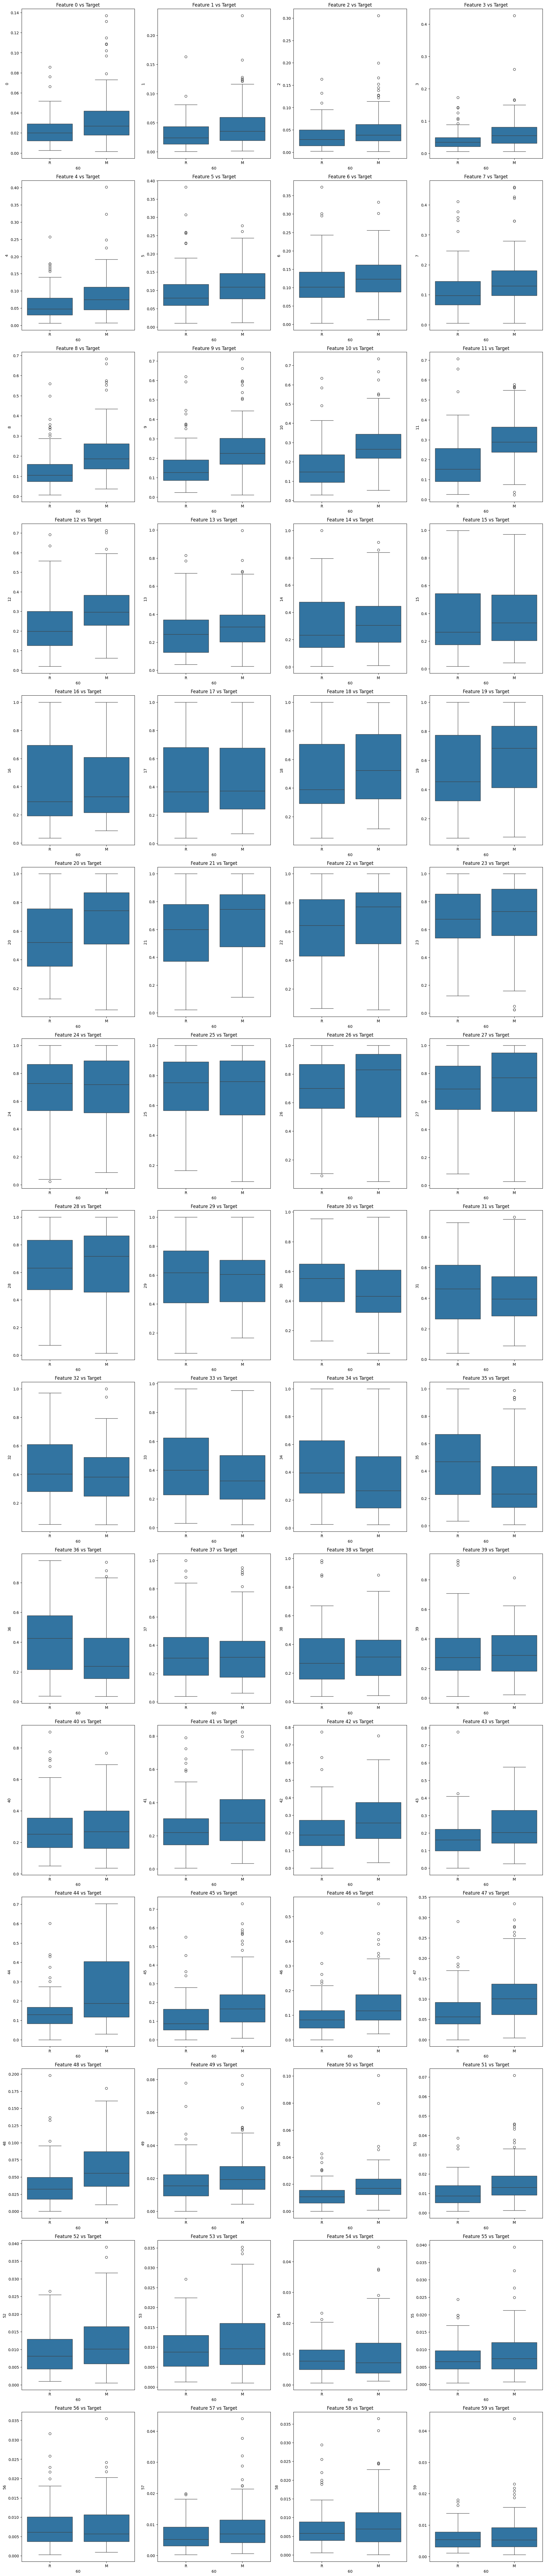

In [3]:
drive.mount('/content/drive')

file_path='/content/drive/My Drive/sonar.csv'
data=pd.read_csv(file_path)

target_column = data.columns[-1]

plt.figure(figsize=(20, 100))

num_features = data.shape[1] - 1

for i in range(num_features):
    plt.subplot((num_features // 4) + 1, 4, i + 1)
    sns.boxplot(x=data[target_column], y=data.iloc[:, i], data=data)
    plt.title(f'Feature {i} vs Target')

plt.tight_layout()
plt.show()

In [4]:
feature_impacts = []

for i, col in enumerate(data.columns[:-1]):

    data_r = data[data['60'] == 'R'][col]
    data_m = data[data['60'] == 'M'][col]


    median_r = data_r.median()
    median_m = data_m.median()


    iqr_r = data_r.quantile(0.75) - data_r.quantile(0.25)
    iqr_m = data_m.quantile(0.75) - data_m.quantile(0.25)


    min_r, max_r = data_r.quantile(0.25), data_r.quantile(0.75)
    min_m, max_m = data_m.quantile(0.25), data_m.quantile(0.75)
    overlap = max(0, min(max_r, max_m) - max(min_r, min_m))

    feature_impacts.append({
        'Feature': col,
        'Median Difference': abs(median_r - median_m),
        'IQR Overlap': overlap,
        'IQR R': iqr_r,
        'IQR M': iqr_m
    })


feature_impacts_df = pd.DataFrame(feature_impacts)
feature_impacts_df.sort_values(by='Median Difference', ascending=False, inplace=True)

print(feature_impacts_df)


   Feature  Median Difference  IQR Overlap   IQR R    IQR M
35      35             0.2345      0.20585  0.4404  0.29925
19      19             0.2304      0.36080  0.4502  0.42310
20      20             0.2208      0.24675  0.4019  0.36050
36      36             0.1887      0.21335  0.3640  0.27245
21      21             0.1461      0.30710  0.4098  0.37730
11      11             0.1362      0.01835  0.1656  0.12650
18      18             0.1353      0.38300  0.4145  0.45240
26      26             0.1305      0.30910  0.3091  0.44105
22      22             0.1302      0.30740  0.3935  0.35520
34      34             0.1286      0.26370  0.3788  0.36985
30      30             0.1183      0.21555  0.2559  0.28620
10      10             0.1177      0.01760  0.1429  0.12500
12      12             0.0984      0.07095  0.1748  0.15335
9        9             0.0981      0.02230  0.1048  0.13335
28      28             0.0870      0.36000  0.3600  0.40950
8        8             0.0810      0.022

In [5]:
X = data.drop(columns=[target_column])
y = data[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


   Feature  Importance
11      11    0.070027
10      10    0.064324
8        8    0.055153
35      35    0.035537
48      48    0.029953
47      47    0.027968
9        9    0.025734
3        3    0.025198
46      46    0.024831
15      15    0.023805
42      42    0.021145
12      12    0.020435
34      34    0.019729
27      27    0.019201
0        0    0.017451
51      51    0.017126
20      20    0.016899
45      45    0.016439
30      30    0.016354
53      53    0.015528
26      26    0.015305
44      44    0.015232
41      41    0.014841
50      50    0.014710
36      36    0.014418
24      24    0.014167
19      19    0.013856
14      14    0.013759
54      54    0.013744
25      25    0.013633
43      43    0.013617
59      59    0.013528
16      16    0.013428
17      17    0.013158
2        2    0.012648
28      28    0.012384
39      39    0.012230
5        5    0.011922
38      38    0.011451
4        4    0.010778
58      58    0.010619
21      21    0.010596
56      56 

In [6]:
feature_impacts_df['Normalized Median Difference'] = (
    feature_impacts_df['Median Difference'] - feature_impacts_df['Median Difference'].min()
) / (feature_impacts_df['Median Difference'].max() - feature_impacts_df['Median Difference'].min())

feature_impacts_df['Inverted IQR Overlap'] = 1 - (
    (feature_impacts_df['IQR Overlap'] - feature_impacts_df['IQR Overlap'].min())
    / (feature_impacts_df['IQR Overlap'].max() - feature_impacts_df['IQR Overlap'].min())
)


feature_importance_df['Normalized Importance'] = (
    feature_importance_df['Importance'] - feature_importance_df['Importance'].min()
) / (feature_importance_df['Importance'].max() - feature_importance_df['Importance'].min())


combined_df = pd.merge(
    feature_impacts_df[['Feature', 'Normalized Median Difference', 'Inverted IQR Overlap']],
    feature_importance_df[['Feature', 'Normalized Importance']],
    on='Feature'
)


combined_df['Combined Score'] = (
    0.4 * combined_df['Normalized Median Difference'] +
    0.4 * combined_df['Normalized Importance'] +
    0.2 * combined_df['Inverted IQR Overlap']
)


combined_df.sort_values(by='Combined Score', ascending=False, inplace=True)



combined_df.columns = [
    'Feature',
    'Normalized Median Difference',
    'Inverted IQR Overlap',
    'Normalized Feature Importance',
    'Combined Importance Score'
]


combined_df = combined_df.round({
    'Normalized Median Difference': 3,
    'Inverted IQR Overlap': 3,
    'Normalized Feature Importance': 3,
    'Combined Importance Score': 3
})


combined_df.sort_values(by='Combined Importance Score', ascending=False, inplace=True)


combined_df.reset_index(drop=True, inplace=True)


print(combined_df.head(10))



  Feature  Normalized Median Difference  Inverted IQR Overlap  \
0      11                         0.581                 0.965   
1      10                         0.502                 0.966   
2      35                         1.000                 0.529   
3       8                         0.345                 0.954   
4      20                         0.942                 0.434   
5       9                         0.418                 0.955   
6      36                         0.805                 0.512   
7      19                         0.983                 0.169   
8      12                         0.419                 0.842   
9      47                         0.189                 0.937   

   Normalized Feature Importance  Combined Importance Score  
0                          1.000                      0.825  
1                          0.912                      0.759  
2                          0.465                      0.692  
3                          0.769    

## Data Preprocessing

In [13]:
top_30_features = combined_df.nlargest(30, 'Combined Importance Score')['Feature'].tolist()
if '60' not in top_30_features:
    top_30_features.append('60')
filtered_data = data[top_30_features]
filtered_data.to_csv('/content/drive/My Drive/sonar_updated.csv', index=False)